In [29]:
import wrds
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

db = wrds.Connection(wrds_username="joselbert")

#downloading the data 
data = db.raw_sql("select date, permno, ret, vol from crsp.msf where permno in (11308, 11850, 12490, 14541, 17830, 18163, 18542, 19502, 19561, 21936, 22111,22592, 22752, 26403, 43449, 47896, 55976, 59176, 59328, 59459) and date>='1978-01-01' and date<='2021-12-31'")
rf = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox= 2000001 and mcaldt>='1978-01-01' and mcaldt<='2021-12-31'")


Loading library list...
Done


In [30]:
#setting the index of the dataframe
index = pd.DatetimeIndex(data.loc[data["permno"] == 11308]["date"].values)

#creating a new dataframe where for each column we have the simple return of each company
#for the column name we have used the ticket name
#first we create an empty dataframe and then we add columns

asset = pd.DataFrame(index = index)
name = ['AMERICAN EXPRESS CO', 'BOEING CO', 'CATERPILLAR TRACTOR INC', 'CHEVRON CORP NEW', 'DISNEY WALT PRODUCTIONS', 'INTERNATIONAL BUSINESS MACHS CO', 'INTEL CORP', 'JOHNSON & JOHNSON', 'JPMORGAN CHASE & CO', 'COCA COLA CO', 'MCDONALDS CORP', '3M CO', 'MERCK & CO INC', 'PFIZER INC','PROCTER & GAMBLE CO', 'TRAVELERS COMPANIES INC', 'UNITED TECHNOLOGIES CORP', 'WALGREENS BOOTS ALLIANCE INC', 'WALMART INC','EXXON MOBIL CORP']
permno = [11308, 11850, 12490, 14541, 17830, 18163, 18542, 19502, 19561, 21936, 22111,22592, 22752, 26403, 43449, 47896, 55976, 59176, 59328, 59459]


#setting the column of the new dataframe
for i,name in enumerate(name):
    asset[name] = data.loc[data["permno"] == permno[i]]["ret"].values

#adjusting the monthly risk free rate to get simple rates
monthly = rf.tmytm/12
asset["TB"] = np.exp(monthly.values/100)-1



In [31]:

#selecting only risky asset from the dataframe
risky = asset.drop(columns="TB")
obs_roll = 120

#using the rolling windows we calculate the mean, the covariance matrix and standard deviations for every estimation period
#having length equal to 120 
mu = risky.rolling(obs_roll).mean()
sig = risky.rolling(obs_roll).cov()
std = risky.rolling(obs_roll).std()


#we select only the rows without NA values 
mu = mu.dropna()
std = std.dropna()
sig = sig.dropna()



In [32]:
#function that gives as output the weight of each portfolios as array
def create_port(mu, sigma, r0, std):
   
    inv_sigma = np.linalg.inv(sigma)
    mu = np.array(mu)
    
    #tangent portfolio
    one = np.ones(shape = (20, 1)).reshape((20,1))
    B = (np.transpose(one) @ inv_sigma) @ mu
    A = (np.transpose(one) @ inv_sigma) @ one
    w_tan = (np.dot(inv_sigma,(mu-r0)) / (B - A*r0))
    TAN = np.array(w_tan)
    
    #gmv portgolios
    one = np.ones(shape = (20, 1))
    w_gmv = np.dot(inv_sigma, one)/ np.dot(inv_sigma, one).sum()
    GMV = np.transpose(w_gmv)
    
    #unlevered risk premium
    tot_w =  (1/std).sum()
    w_risk_premium =(1/std)/tot_w
    RP = np.array(w_risk_premium)
    
    #equally weighted 
    EW = np.array(np.ones(shape=(20))*(1/20))
    
    
    return TAN, GMV, RP, EW

In [33]:
#now for every strategy we generate a matrix of weight tan, ew, rp, gmv for each date
#for every row that we need to insert in these matrix, we select the corresponding row from the dataFrames containing the estimation 
#of the mean, the covariance matrix and the standard deviation
for i in range(len(mu)-1):
    mean = mu.iloc[i]
    stand = std.iloc[i]
    sigma_matrix = sig.iloc[0+i*20:20+i*20]
    risk_free = asset.TB.iloc[120+i]
    
    if i == 0:
        #at the first iteration we create the four vectors
        tan, gmv, rp, ew =  create_port(mean , sigma_matrix , risk_free, stand)
        
    else:
        #for the others step we insert the weight vectors as row inside these matrices using the function vstack 
        #that insert a row at the end of a matrix
        w =  create_port(mean , sigma_matrix , risk_free, stand)
        tan = np.vstack([tan, w[0]])
        gmv = np.vstack([gmv, w[1]])
        rp = np.vstack([rp, w[2]])
        ew = np.vstack([ew, w[3]])

        
#now for the period to estimate the perfomance of the portfolios we multiply item*item the element of the 
#weights matrices and the return of each asset 
risky_period = risky.loc[asset.index>="1988-01-01"]
TAN = tan*risky_period
GMV = gmv*risky_period
EW = ew*risky_period
RP = rp*risky_period

#now in order to obtain the performance of the portfolio we sum by row what we have calculated at the step before 
#in this way we are summing up the return of each asset multiplied by the weight that the portfolio put on it 
#we create a DataFrame containing all the portfolios
port = pd.DataFrame(index=risky_period.index)
port["TAN"] = TAN.sum(axis=1)
port["GMV"] = GMV.sum(axis=1)
port["RP"] = RP.sum(axis=1)
port["EW"] = EW.sum(axis=1)



In [34]:
risk_free = asset.loc[asset.index >="1988-01-01", "TB"]
mean = port.mean()
std = port.std()
print(f"Annualized Mean of return\n{mean*12}")
print("\nAnnualized Mean of risk free asset", risk_free.mean()*12)
print(f"\nStandard deviation of return\n{std*np.sqrt(12)}\n")


#now we need to calculate the sharpe ratios
for i in port.columns:
    print(f"Sharpe Ratio of {i}:  {12*(port[i] - risk_free).mean()/(np.sqrt(12)*port[i].std())}")



Annualized Mean of return
TAN    0.059437
GMV    0.105238
RP     0.141608
EW     0.146330
dtype: float64

Annualized Mean of risk free asset 0.027341470623410094

Standard deviation of return
TAN    0.257632
GMV    0.133114
RP     0.137769
EW     0.143713
dtype: float64

Sharpe Ratio of TAN:  0.12457897272831565
Sharpe Ratio of GMV:  0.5851832458535386
Sharpe Ratio of RP:  0.8294102432039768
Sharpe Ratio of EW:  0.8279564790975739


(f)
We can see that the SR is the highest for the RP portfolio due to its high excess return relative to its risk (std). The SR is of the EW portfolio is almost identical, whereas the SR of the GMV portfolio is significantly lower. This is due to the lower annualized mean of returns compared to the RP and EW portfolio, while the std is very similar. The TAN portfolio has significantly the lowest mean of returns and also the highest std which results in the worst sharpe ratio of the 4 portfolios.

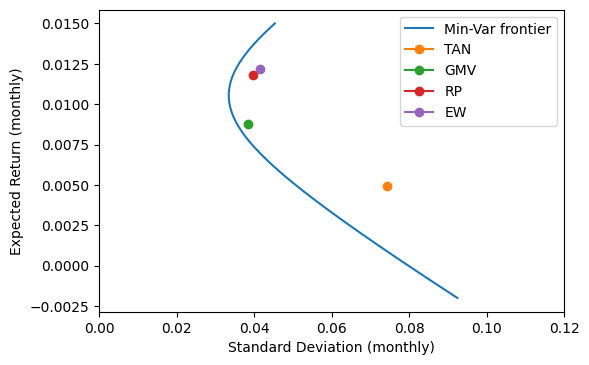

In [38]:
#plot the minimum variance frontier and put the portfolios obtained in it 
import matplotlib
matplotlib.rcParams["figure.dpi"] = 100

def frontier(mu_p):
    mu_p = mu_p
    data =  asset.loc[port.index[port.index < "2019-01-01" ]]
    risky = data.drop(columns="TB")
    sigma_inv = np.linalg.inv(risky.cov()) 
    one = np.ones(shape=(20,1))
    mu = np.array(risky.mean())
    a = np.dot(sigma_inv,one).sum()
    b = np.dot(sigma_inv,mu).sum()
    c = np.dot(np.dot(np.transpose(mu), sigma_inv) , mu)  
    delta = a*c -b**2
    return np.sqrt((a*mu_p**2 - 2*b*mu_p + c)/delta)

y = np.linspace(-0.002,0.015,1000)
plt.plot(frontier(y), y, label = "Min-Var frontier")
plt.xlim((0,0.12))

#we can see the performance of the portfolios  and of the risk free asset 
for i in port.columns:
    plt.plot(port[i].std(), port[i].mean(), marker="o", label=i)

plt.legend()
plt.xlabel("Standard Deviation (monthly)")
plt.ylabel("Expected Return (monthly)")
plt.show()


We can see that the GMV portfolio is very close to the MV-frontier and therefore is almost mean-variance efficient. 
The RP portfolio is a bit more far away but stil very close to the MV-frontier. A similar result can be observed for the EW portfolio. The TAN porftolio, however, is a lot more far away from the frontier and we can therefore conclude that it is not even close to be mean-variance efficient.


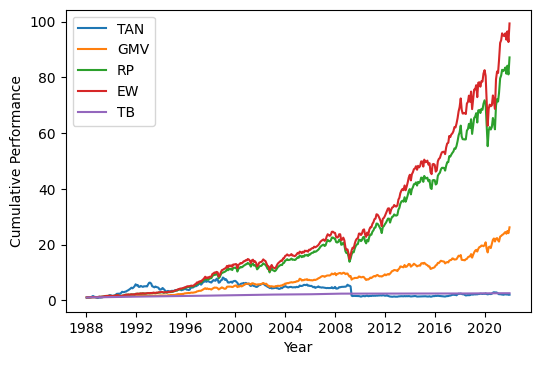

In [36]:

#we can see the performances of the strategies

plt.plot((1+port).cumprod(), label = port.columns)
plt.plot((1+risk_free).cumprod(), label = "TB")
plt.legend()
plt.ylabel("Cumulative Performance")
plt.xlabel("Year")
plt.show()
